In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import pandas as pd
import numpy as np
import scipy.stats
import ratmetab
import itertools
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import attila_utils
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
data = ratmetab.read_all_data()

In [3]:
def insert_centered_LIscore(dataset, data=data):
    df = data[dataset]
    s = df.LIscore - df.LIscore.mean()
    val = pd.concat([pd.DataFrame({'LIscore cent.': s}, index=df.index), df], axis=1)
    return(val)

def insert_age(dataset, data=data):
    df = data[dataset]
    l = [(lambda g: 'Y' if g == 'Y' else 'A')(group) for group in df.Group]
    val = pd.concat([pd.DataFrame({'Age': l}, index=df.index), df], axis=1)
    return(val)

data = {dataset: insert_age(dataset, data=data) for dataset in data.keys()}
data = {dataset: insert_centered_LIscore(dataset, data=data) for dataset in data.keys()}

In [4]:
codebookpath = '../../resources/rat-metabolites/Rat_codebook_27_Oct_2022.csv'
codebook = pd.read_csv(codebookpath, index_col='MetaboliteName')
codebook['Metabolite'] = codebook.index
codebook = ratmetab.add_subclassification_to_df(codebook, ratmetab.read_subclassification(), class_col='AnalyteClass')
codebook

,Assay,AnalyteClass,HMDB_UID,CAS_UID,UnitofConcentration,metabolite,Metabolite,Subclass
MetaboliteName,,,,,,,,
22R-Hydroxycholesterol,Oxysterol assay,Free_Oxysterols,HMDB0004035,CAS-17954-98-2,[fmol/mg tissue],_22R_OHC,22R-Hydroxycholesterol,Free_Oxysterols_Enzymatic
24S-Hydroxycholesterol,Oxysterol assay,Free_Oxysterols,HMDB01419,CAS-474-73-7,[fmol/mg tissue],_24S_OHC,24S-Hydroxycholesterol,Free_Oxysterols_Enzymatic
"24,25-Epoxycholesterol",Oxysterol assay,Free_Oxysterols,NaN,CAS-77058-74-3,[fmol/mg tissue],_24_25_EC,"24,25-Epoxycholesterol",Free_Oxysterols_Enzymatic
"24,25-Dihydrolanosterol",Oxysterol assay,Free_Oxysterols,HMDB0006839,CAS-79-62-9,[fmol/mg tissue],_24_DHLan,"24,25-Dihydrolanosterol",Free_Oxysterols_Enzymatic
25-Hydroxycholesterol,Oxysterol assay,Free_Oxysterols,HMDB06247,CAS-2140-46-7,[fmol/mg tissue],_25_OHC,25-Hydroxycholesterol,Free_Oxysterols_Enzymatic
...,...,...,...,...,...,...,...,...
Phosphatidylserine aa 42:5,Lipid assay,Phosphatidylserines,"HMDB0112535, HMDB0112536, HMDB0112561, HMDB011...",NaN,[pmol/mg tissue],psaac425,Phosphatidylserine aa 42:5,Phosphatidylserines
Phosphatidylserine ae 34:2,Lipid assay,Phosphatidylserines,NaN,NaN,[pmol/mg tissue],psaec342,Phosphatidylserine ae 34:2,Phosphatidylserines
Phosphatidylserine ae 36:1,Lipid assay,Phosphatidylserines,NaN,NaN,[pmol/mg tissue],psaec361,Phosphatidylserine ae 36:1,Phosphatidylserines


## Data transformations

In [5]:
def scipy_transfor_helper(s, fun=scipy.stats.boxcox):
    try:
        val = fun(s)[0]
    except(ValueError):
        val = s.apply(lambda x: np.nan)
    res = pd.Series(val, index=s.index)
    return(res)

def myboxcox(s): return(scipy_transfor_helper(s, scipy.stats.boxcox))
def myyeojohnson(s): return(scipy_transfor_helper(s, scipy.stats.yeojohnson))

def transform_data(aclass, transformation=np.log, dat=data['blood'], codebook=codebook, class_col='AnalyteClass'):
    aclass_metabolites = codebook.loc[codebook[class_col] == aclass].index
    sel_metabolites = list(set(dat.columns).intersection(set(aclass_metabolites)))
    sel_cols = ['LIscore cent.', 'Age'] + sel_metabolites
    df = dat.loc[:, sel_metabolites]
    df = df.apply(transformation, axis=1)
    # standardization
    df = df.apply(lambda x: (x - df.mean(axis=0)) / df.std(axis=0), axis=1)
    return(df)

transformations = {
    'no': lambda x: x,
    'log': np.log,
    'Box-Cox': myboxcox,
    'Yeo-Johnson': myyeojohnson,
}

def distplot_aclass(aclass, transformations=transformations, dat=data['blood'], codebook=codebook, class_col='AnalyteClass'):
    ntrans = len(transformations)
    fig, ax = plt.subplots(1, ntrans, figsize=(4 * ntrans, 4))
    std_trans_dfs = {name: transform_data(aclass, transformation=trans, dat=dat, codebook=codebook, class_col=class_col) for name, trans in transformations.items()}
    df0 = std_trans_dfs[list(transformations.keys())[0]]
    stepsize = np.int64(np.floor(len(mcolors.CSS4_COLORS) / df0.shape[1]))
    colors = list(mcolors.CSS4_COLORS.values())[::stepsize]
    for metabolite, color in zip(df0, colors):
        for i, items in enumerate(zip(ax, std_trans_dfs.keys(), std_trans_dfs.values())):
            axi, name, tdf = items
            label = metabolite if i == 0 else None
            sm.qqplot(tdf[metabolite], label=label, ax=axi, linewidth=1, linestyle='solid', color=color, markerfacecolor=color, marker='.', line='45')
            axi.set_title(name + ' transformation')
            axi.set_xlabel('')
            axi.set_ylabel('')
    fig.legend(ncol=ntrans, loc='upper center', bbox_to_anchor=(0.5, 0), title=aclass + ' in data set')
    fig.suptitle(aclass + ': normal QQ plots')
    fig.supxlabel('Theoretical quantiles')
    fig.supylabel('Sample quantiles')
    return((fig, ax))

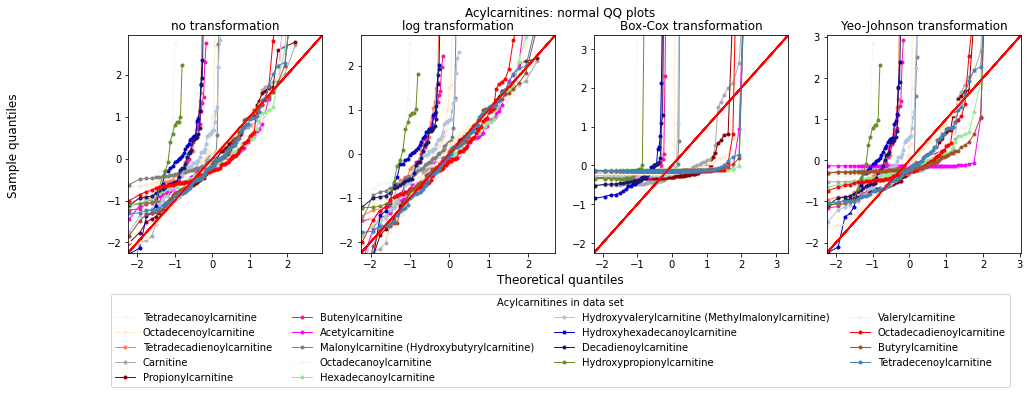

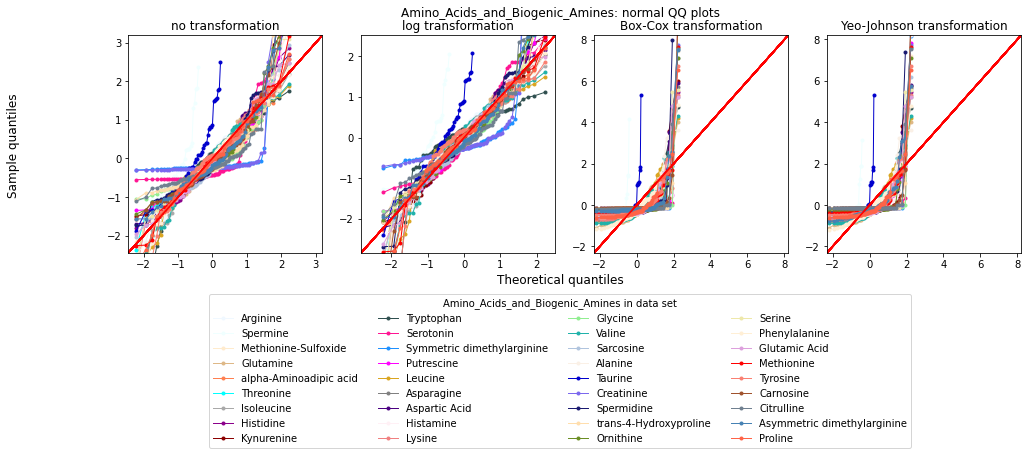

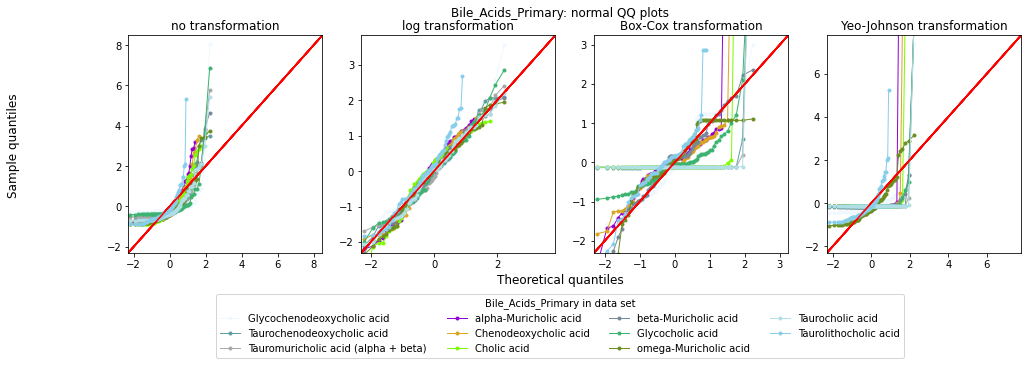

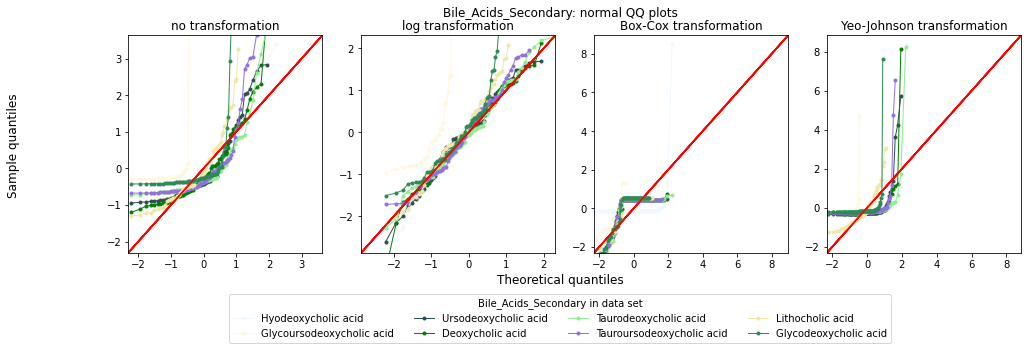

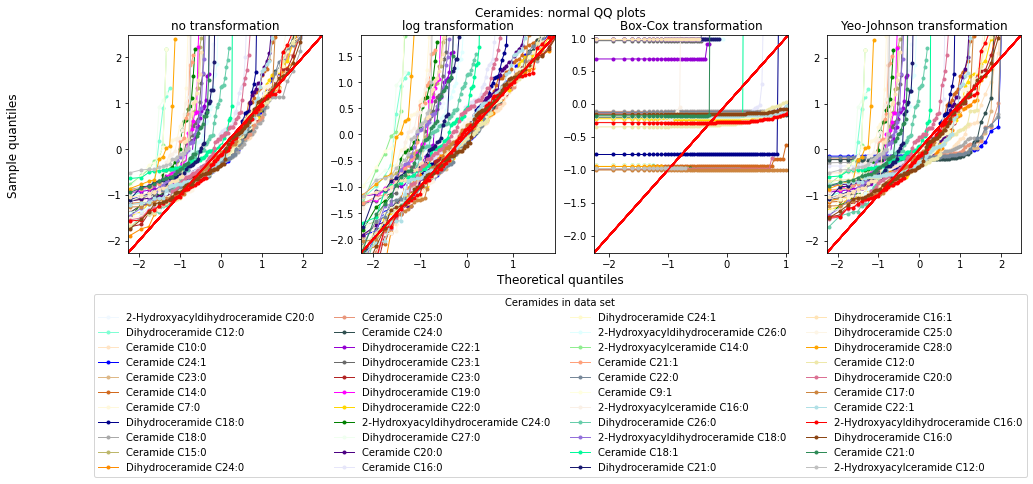

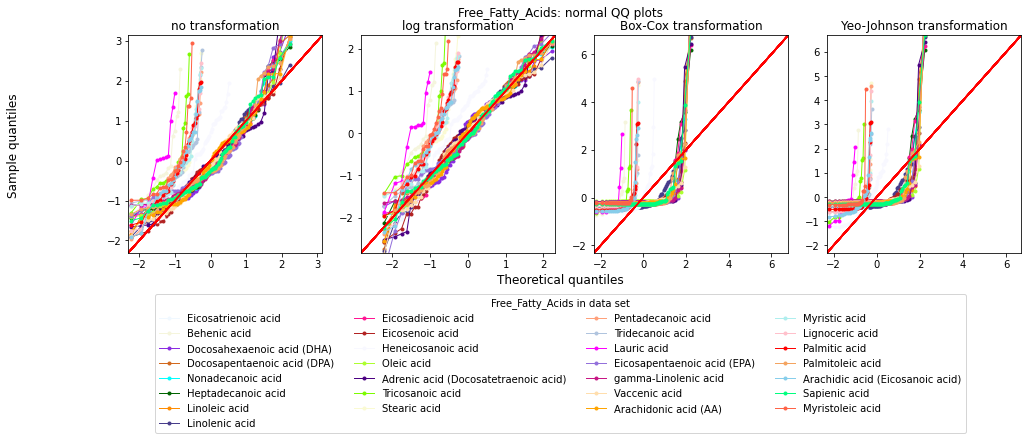

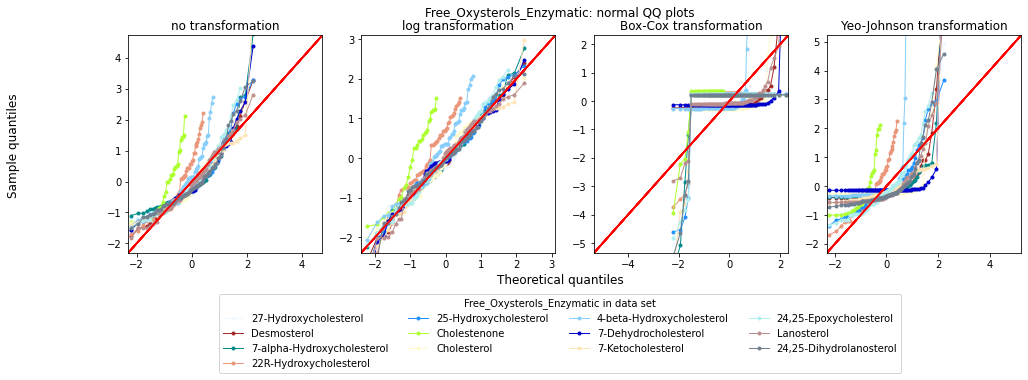

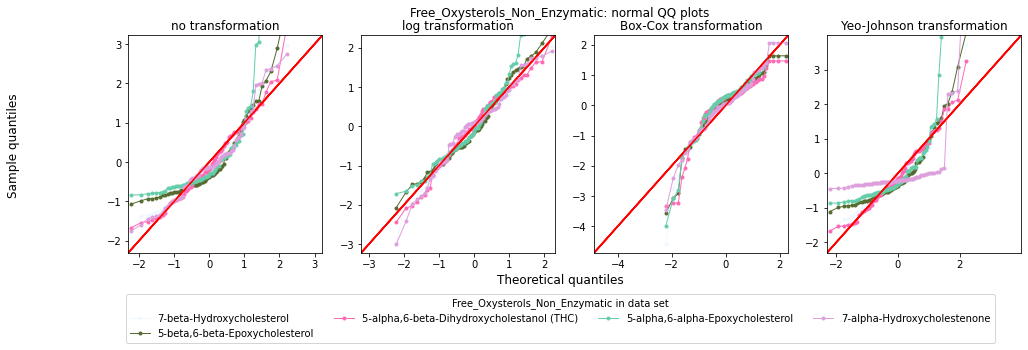

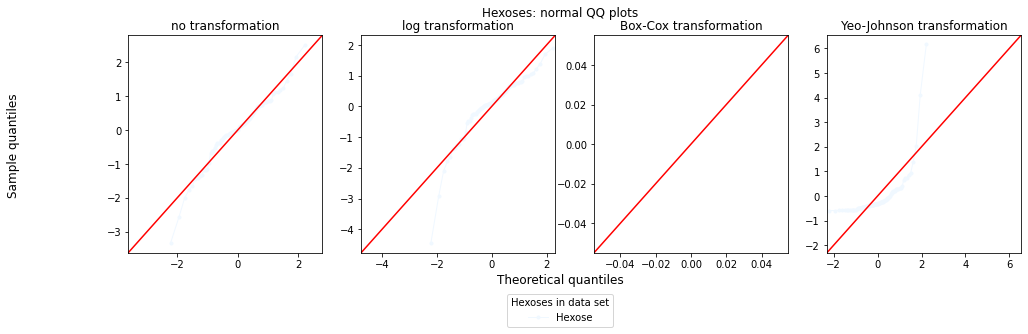

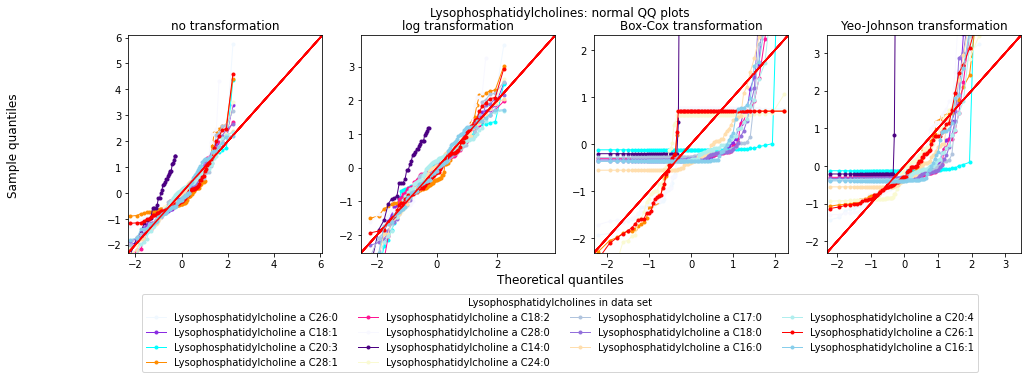

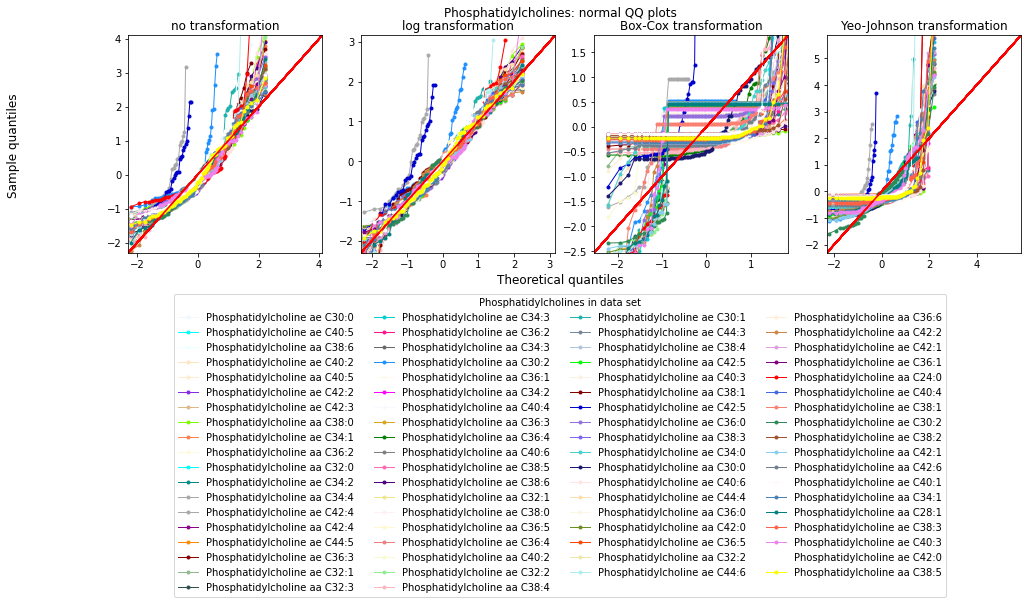

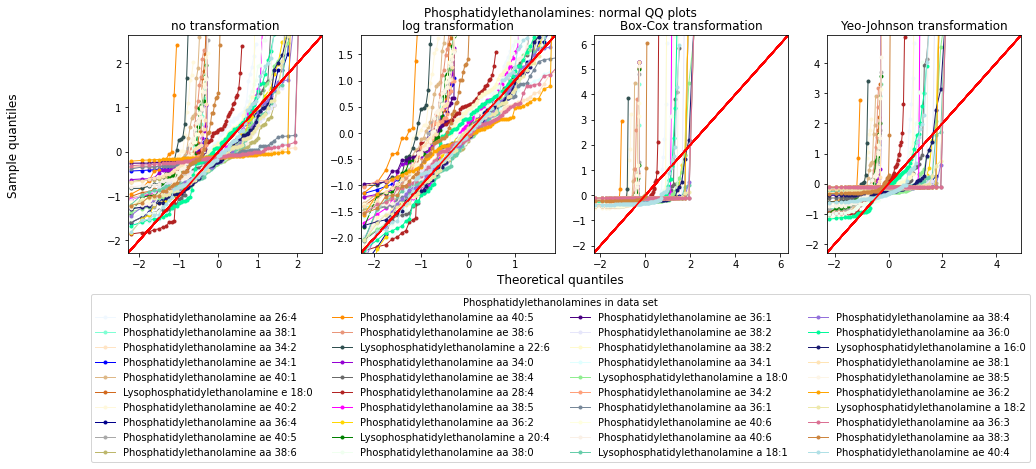

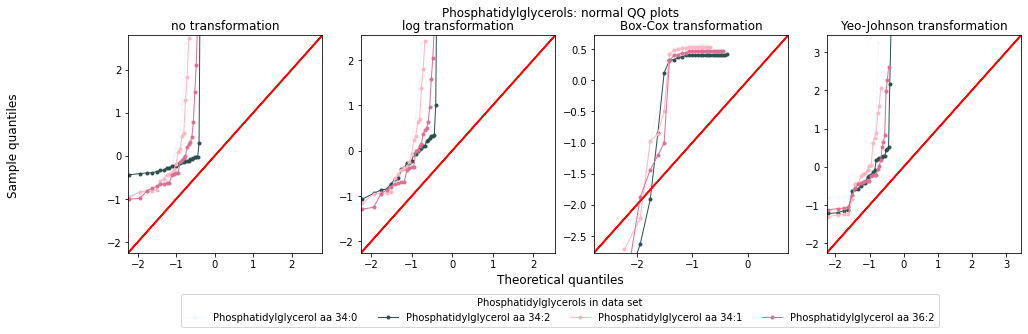

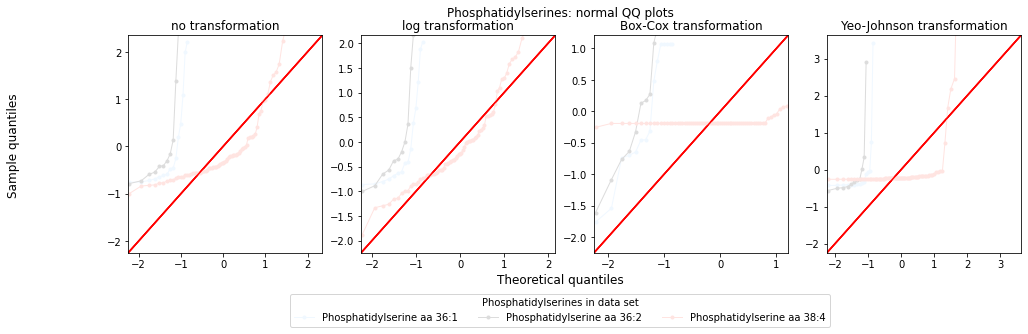

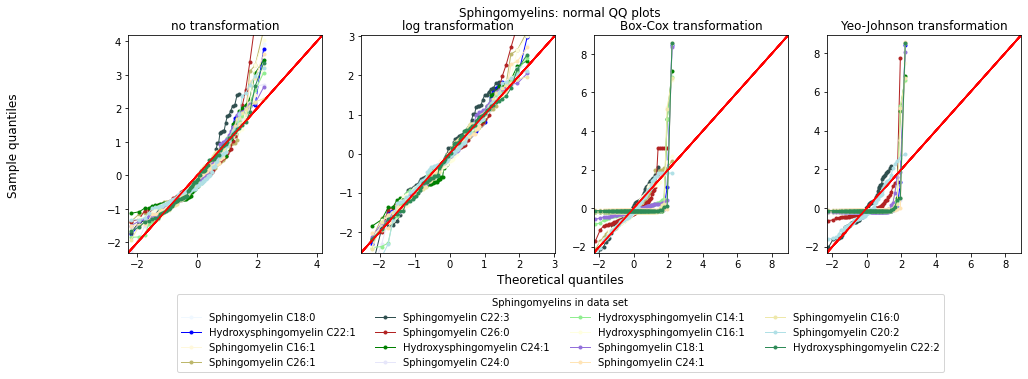

In [6]:
%%capture --no-display
class_col = 'Subclass'
subclasses = list(np.unique(codebook[class_col]))
subclasses.remove('Bile_Acids')
for aclass in subclasses:
    fig, ax = distplot_aclass(aclass, dat=data['blood'], codebook=codebook, class_col=class_col)
    attila_utils.savefig(fig, 'transformed-QQ-' + aclass)

## Mixed models M4, M5

In [7]:
#fm4 = 'Level ~ Age + Age : Q("LIscore cent.")'
fm4 = 'Level ~ C(Age, levels=["Y", "A"]) + Age : Q("LIscore cent.")'
fm5 = 'Level ~ C(Age, levels=["Y", "A"]) * Q("LIscore cent.")'

def fit_aclass_data(aclass, formula, transformation=transformations['no'], dat=data['blood'], codebook=codebook, class_col='AnalyteClass'):
    df = transform_data(aclass, transformation=transformation, dat=dat, codebook=codebook, class_col=class_col)
    sel_metabolites = df.columns
    df = df.stack(dropna=False).to_frame('Level')
    df['Age'] = np.repeat(dat.Age, len(sel_metabolites)).to_list()
    df['LIscore cent.'] = np.repeat(dat['LIscore cent.'], len(sel_metabolites)).to_list()
    df['Metabolite'] = df.index.get_level_values(1)
    df = df.dropna()
    fmod = smf.mixedlm(formula, data=df, groups='Metabolite').fit()
    return(fmod)

def extract_fit_info(fmod, aclass, transformation_name):
    fmod.summary()
    d = {'Estimate': fmod.params, 'SE': fmod.bse, 'p': fmod.pvalues}
    ll = [a.to_list() for a in d.values()]
    l = itertools.chain(*ll)
    ix = pd.MultiIndex.from_product([d.keys(), d['Estimate'].index])
    df = pd.DataFrame({aclass: l}, index=ix).transpose()
    df[('General', 'Converged')] = fmod.converged
    df[('General', 'Fitted model')] = fmod
    df[('General', 'Transformation')] = transformation_name
    return(df)

def process_aclass(aclass, formula, transformation_name='no', dat=data['blood'], codebook=codebook, class_col='AnalyteClass'):
    transformation = transformations[transformation_name]
    fmod = fit_aclass_data(aclass, formula, transformation=transformation, dat=dat, codebook=codebook, class_col=class_col)
    df = extract_fit_info(fmod, aclass, transformation_name)
    return(df)

### Fitting mixed M4

In [8]:
class_col = 'AnalyteClass'
l = [process_aclass(aclass, fm4, transformation_name='no', class_col=class_col) for aclass in np.unique(codebook[class_col])]
results_m4 = pd.concat(l, axis=0)

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/usr/loc

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn

In [9]:
class_col = 'Subclass'
l = [process_aclass(aclass, fm4, transformation_name='no', class_col=class_col) for aclass in subclasses]
results_m4_subcls = pd.concat(l, axis=0)

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/usr/loc

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/usr/loc

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  wa

In [10]:
class_col = 'AnalyteClass'
l = [process_aclass(aclass, fm4, transformation_name='log', class_col=class_col) for aclass in np.unique(codebook[class_col])]
results_m4_log = pd.concat(l, axis=0)

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/usr/loc

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/usr/loc

In [11]:
class_col = 'Subclass'
l = [process_aclass(aclass, fm4, transformation_name='log', class_col=class_col) for aclass in subclasses]
results_m4_log_subcls = pd.concat(l, axis=0)

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/usr/loc

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/usr/local/an

In [12]:
results_m4_log_subcls

Estimate                                 \
                                    Intercept C(Age, levels=["Y", "A"])[T.A]   
Acylcarnitines                   2.839677e-16                       0.081303   
Amino_Acids_and_Biogenic_Amines -1.452446e-16                      -0.031297   
Bile_Acids_Primary               8.372161e-16                       0.227210   
Bile_Acids_Secondary            -1.850137e-17                      -0.003934   
Ceramides                       -6.167576e-01                       0.907082   
Free_Fatty_Acids                 5.736844e-16                       0.155241   
Free_Oxysterols_Enzymatic       -3.861829e-01                       0.615356   
Free_Oxysterols_Non_Enzymatic   -4.428966e-01                       0.716341   
Hexoses                          5.563272e-01                      -0.824384   
Lysophosphatidylcholines         1.801474e-15                       0.383257   
Phosphatidylcholines            -7.481990e-01                       1.136766   
Phosphatidylethanolamines        2.501565e-15                       0.819244   
Phosphatidylglycerols           -4.982612e-01                       0.656413   
Phosphatidylserines             -2.505941e-01                       0.393401   
Sphingomyelins                  -5.903503e-01                       0.873627   

                                                           \
                                Age[A]:Q("LIscore cent.")   
Acylcarnitines                                   0.002096   
Amino_Acids_and_Biogenic_Amines                  0.000831   
Bile_Acids_Primary                              -0.001929   
Bile_Acids_Secondary                            -0.002222   
Ceramides                                       -0.002213   
Free_Fatty_Acids                                -0.000562   
Free_Oxysterols_Enzymatic                       -0.003206   
Free_Oxysterols_Non_Enzymatic                   -0.004137   
Hexoses                                         -0.000352   
Lysophosphatidylcholines                        -0.001030   
Phosphatidylcholines                            -0.001417   
Phosphatidylethanolamines                        0.000321   
Phosphatidylglycerols                            0.003221   
Phosphatidylserines                             -0.000422   
Sphingomyelins                                   0.001362   

                                                                          \
                                Age[Y]:Q("LIscore cent.") Metabolite Var   
Acylcarnitines                                   0.000960   0.000000e+00   
Amino_Acids_and_Biogenic_Amines                 -0.000968   0.000000e+00   
Bile_Acids_Primary                              -0.000069   1.232595e-32   
Bile_Acids_Secondary                             0.000753   0.000000e+00   
Ceramides                                       -0.001611   6.386290e-07   
Free_Fatty_Acids                                 0.000968   0.000000e+00   
Free_Oxysterols_Enzymatic                       -0.000407   7.672792e-05   
Free_Oxysterols_Non_Enzymatic                    0.000487   3.712045e-09   
Hexoses                                          0.000577   1.000000e+00   
Lysophosphatidylcholines                         0.001434   0.000000e+00   
Phosphatidylcholines                             0.000555   8.470638e-05   
Phosphatidylethanolamines                       -0.001145   0.000000e+00   
Phosphatidylglycerols                           -0.000683   1.649344e-03   
Phosphatidylserines                              0.001804   1.329181e-06   
Sphingomyelins                                   0.000138   2.342549e-05   

                                           SE                                 \
                                    Intercept C(Age, levels=["Y", "A"])[T.A]   
Acylcarnitines                   1.038156e+06                       0.073538   
Amino_Acids_and_Biogenic_Amines  5.387330e+05                       0.044061   
Bile_Acids_Primary       

### Fitting mixed M5

In [13]:
class_col = 'AnalyteClass'
l = [process_aclass(aclass, fm5, transformation_name='no', class_col=class_col) for aclass in np.unique(codebook[class_col])]
results_m5 = pd.concat(l, axis=0)

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/usr/loc

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn

In [14]:
class_col = 'AnalyteClass'
l = [process_aclass(aclass, fm5, transformation_name='log', class_col=class_col) for aclass in np.unique(codebook[class_col])]
results_m5_log = pd.concat(l, axis=0)

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/usr/loc

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 8.763237
  warnings.warn(msg, ConvergenceWarning)
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarn

In [15]:
class_col = 'Subclass'
l = [process_aclass(aclass, fm5, transformation_name='log', class_col=class_col) for aclass in subclasses]
results_m5_log_subcls = pd.concat(l, axis=0)

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/usr/loc

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/usr/local/an

In [16]:
results_m5_log

Estimate                                 \
                                    Intercept C(Age, levels=["Y", "A"])[T.A]   
Acylcarnitines                   2.840004e-16                       0.081303   
Amino_Acids_and_Biogenic_Amines -1.451817e-16                      -0.031297   
Bile_Acids                      -7.456179e-02                       0.136545   
Ceramides                       -6.167576e-01                       0.907082   
Free_Fatty_Acids                 5.736484e-16                       0.155241   
Free_Oxysterols                 -4.026501e-01                       0.644847   
Hexoses                          5.563272e-01                      -0.824384   
Lysophosphatidylcholines         1.801389e-15                       0.383257   
Phosphatidylcholines            -7.481990e-01                       1.136766   
Phosphatidylethanolamines        2.501594e-15                       0.819244   
Phosphatidylglycerols           -4.982612e-01                       0.656413   
Phosphatidylserines             -2.505941e-01                       0.393401   
Sphingomyelins                  -5.903503e-01                       0.873627   

                                                    \
                                Q("LIscore cent.")   
Acylcarnitines                            0.000960   
Amino_Acids_and_Biogenic_Amines          -0.000968   
Bile_Acids                                0.000255   
Ceramides                                -0.001611   
Free_Fatty_Acids                          0.000968   
Free_Oxysterols                          -0.000143   
Hexoses                                   0.000577   
Lysophosphatidylcholines                  0.001434   
Phosphatidylcholines                      0.000555   
Phosphatidylethanolamines                -0.001145   
Phosphatidylglycerols                    -0.000683   
Phosphatidylserines                       0.001804   
Sphingomyelins                            0.000138   

                                                                                   \
                                C(Age, levels=["Y", "A"])[T.A]:Q("LIscore cent.")   
Acylcarnitines                                                           0.001137   
Amino_Acids_and_Biogenic_Amines                                          0.001799   
Bile_Acids                                                              -0.002290   
Ceramides                                                               -0.000603   
Free_Fatty_Acids                                                        -0.001530   
Free_Oxysterols                                                         -0.003334   
Hexoses                                                                 -0.000930   
Lysophosphatidylcholines                                                -0.002464   
Phosphatidylcholines                                                    -0.001973   
Phosphatidylethanolamines                                                0.001466   
Phosphatidylglycerols                                                    0.003905   
Phosphatidylserines                                                     -0.002227   
Sphingomyelins                                                           0.001224   

                                                          SE  \
                                Metabolite Var     Intercept   
Acylcarnitines                    0.000000e+00  1.038156e+06   
Amino_Acids_and_Biogenic_Amines   0.000000e+00  5.387330e+05   
Bile_Acids                        6.557037e-05  5.118907e-02   
Ceramides                         6.386290e-07  3.862061e-02   
Free_Fatty_Acids                  0.000000e+00  7.475822e+05   
Free_Oxysterols                   5.596192e-05  4.999052e-02   
Hexoses                           1.000000e+00  9.633036e-01   
Lysophosphatidylcholines          0.000000e+00  8.478180e+05   
Phosphatidylcholines              8.470638e-05  2.168005e-02   
Phosphatidylethanolamines         0.000000e+0

In [17]:
pd.set_option('max_colwidth', 200)
l = [
    'Average metabolite level in young rats with average cognitive performance',
    'Change of metabolite level in aged rats w.r.t young rats (avg. cog. perf.)',
    'Association of metabolite level to LIscore (worsening cog. perf.) in aged rats',
    'Association of metabolite level to LIscore (worsening cog. perf.) in young rats',
    'Variability of metabolite level across all metabolites in class',
]
df = pd.DataFrame({'Interpretation': l}, index=results_m4_log.xs('Estimate', axis=1, level=0).columns)
df.rename_axis('Parameter', axis=0)

,Interpretation
Parameter,
Intercept,Average metabolite level in young rats with average cognitive performance
"C(Age, levels=[""Y"", ""A""])[T.A]",Change of metabolite level in aged rats w.r.t young rats (avg. cog. perf.)
"Age[A]:Q(""LIscore cent."")",Association of metabolite level to LIscore (worsening cog. perf.) in aged rats
"Age[Y]:Q(""LIscore cent."")",Association of metabolite level to LIscore (worsening cog. perf.) in young rats
Metabolite Var,Variability of metabolite level across all metabolites in class


In [18]:
pd.set_option('max_colwidth', 200)
l = [
    'Average metabolite level in young rats with average cognitive performance',
    'Change of metabolite level in aged rats w.r.t young rats (avg. cog. perf.)',
    'Association of metabolite level to LIscore (worsening cog. perf.) in young rats',
    'Association of metabolite level to LIscore (worsening cog. perf.) in aged rats relative to that in young rats',
    'Variability of metabolite level across all metabolites in class',
]
df = pd.DataFrame({'Interpretation': l}, index=results_m5_log.xs('Estimate', axis=1, level=0).columns)
df.rename_axis('Parameter', axis=0)

,Interpretation
Parameter,
Intercept,Average metabolite level in young rats with average cognitive performance
"C(Age, levels=[""Y"", ""A""])[T.A]",Change of metabolite level in aged rats w.r.t young rats (avg. cog. perf.)
"Q(""LIscore cent."")",Association of metabolite level to LIscore (worsening cog. perf.) in young rats
"C(Age, levels=[""Y"", ""A""])[T.A]:Q(""LIscore cent."")",Association of metabolite level to LIscore (worsening cog. perf.) in aged rats relative to that in young rats
Metabolite Var,Variability of metabolite level across all metabolites in class


In [19]:
def get_summary(aclass, results=results_m4_log):
    print(aclass, '\n')
    m = results.loc[aclass, ('General', 'Fitted model')]
    print(m.summary(), '\n', '\n')
    return(m)

m = get_summary('Phosphatidylcholines')
m = get_summary('Sphingomyelins')

Phosphatidylcholines 

                  Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       Level     
No. Observations:       5414          Method:                   REML      
No. Groups:             74            Scale:                    0.6997    
Min. group size:        26            Log-Likelihood:           -6734.2721
Max. group size:        75            Converged:                Yes       
Mean group size:        73.2                                              
--------------------------------------------------------------------------
                               Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------
Intercept                      -0.748    0.022 -34.511 0.000 -0.791 -0.706
C(Age, levels=["Y", "A"])[T.A]  1.137    0.026  43.852 0.000  1.086  1.188
Age[A]:Q("LIscore cent.")      -0.001    0.000  -4.860 0.000 -0.002 -0.001
Age[Y]:Q("LIscore cen

### Goodness of fit

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


['named-figure/residuals-QQ-plot-M4-M4_log_subcls.png',
 'named-figure/residuals-QQ-plot-M4-M4_log_subcls.pdf']

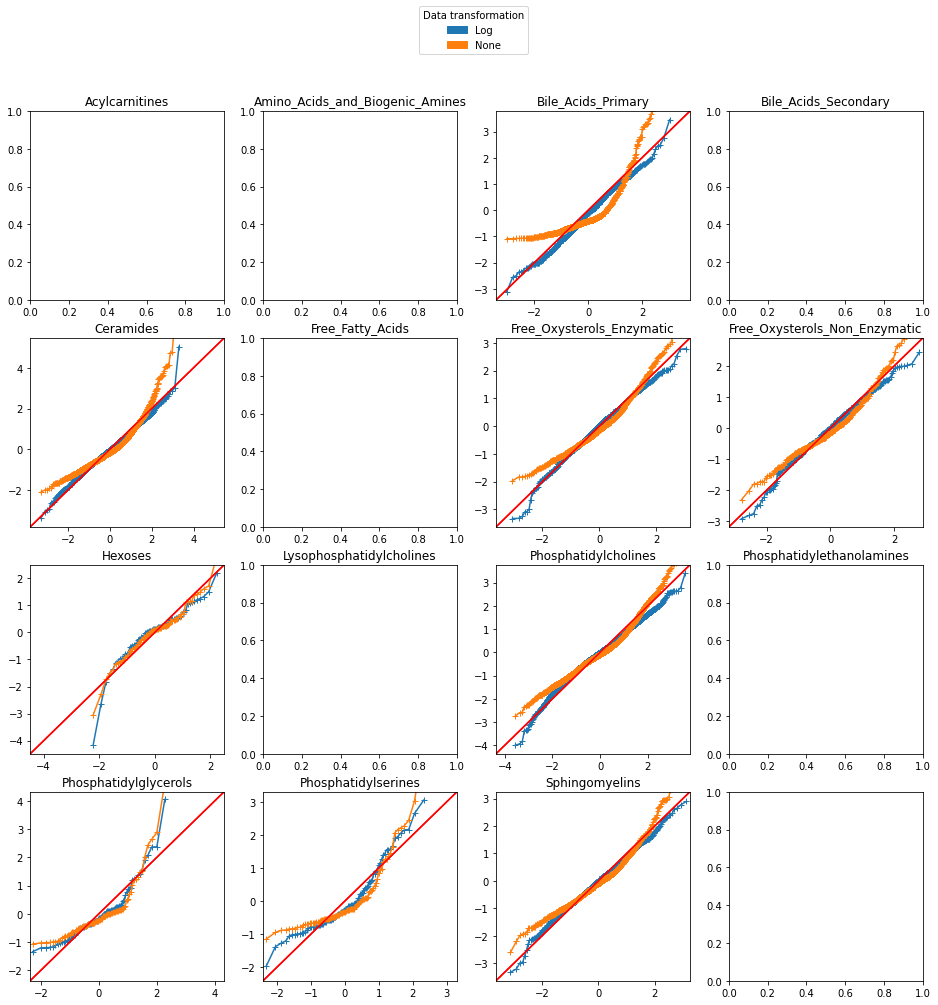

In [20]:
def resid_QQ(fitres0, fitres1, labels=['Log', 'None'], legendtitle='Data transformation'):
    fig, ax = plt.subplots(4, 4, figsize=(16, 16))
    for axi, aclass in zip(ax.ravel(), fitres0.index):
        m0 = fitres0.loc[aclass, ('General', 'Fitted model')]
        m1 = fitres1.loc[aclass, ('General', 'Fitted model')]
        try:
            sm.qqplot(m0.resid, ax=axi, marker='+', line='45', color='C0', linestyle='solid')
        except(ValueError):
            None
        try:
            sm.qqplot(m1.resid, ax=axi, marker='+', line='45', color='C1', linestyle='solid')
        except(ValueError):
            None
        axi.set_title(aclass)
        axi.set_xlabel('')
        axi.set_ylabel('')
    handles = [mpatches.Patch(color=c) for c in ['C0', 'C1']]
    fig.legend(handles, labels, title=legendtitle, loc='center', bbox_to_anchor=(0.51, 0.95))
    return((fig, ax))

fig, ax = resid_QQ(results_m4_log_subcls, results_m4_subcls, labels=['Log', 'None'], legendtitle='Data transformation')
attila_utils.savefig(fig, 'residuals-QQ-plot-M4-M4_log_subcls')

The next plot is identical to the one above because M4 and M5 fit the data equally well.

## Inference

In [21]:
def plot_param(param='Age[A]:Q("LIscore cent.")', results=results_m4, model='Mixed M4'):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
    yticks = np.arange(results.shape[0])
    Estimate = results[('Estimate', param)]
    SE = results[('SE', param)]
    converged = results[('General', 'Converged')]
    color = converged.apply(lambda b: 'C0' if b else 'red')
    handles = [mpatches.Patch(color=c) for c in ['C0', 'red']]
    labels = ['yes', 'no']
    fig.legend(handles, labels, title='Converged?', loc='center', bbox_to_anchor=(0.51, 0.85))
    ax[0].barh(yticks, Estimate, xerr=SE, color=color)
    ax[0].set_yticks(yticks)
    ax[0].set_yticklabels(results.index)
    ax[0].set_title('Estimates')
    ax[0].grid(axis='both')
    pval = results[('p', param)]
    ax[1].scatter(x=pval, y=yticks, c=color)
    ax[1].grid(axis='both')
    ax[1].set_title('p-values')
    ax[1].set_xscale('log')
    fig.suptitle(model + ' Parameter: ' + param)
    return((fig, ax))

### Effect of age

['named-figure/estimates-Age_effect-M4_log.png',
 'named-figure/estimates-Age_effect-M4_log.pdf']

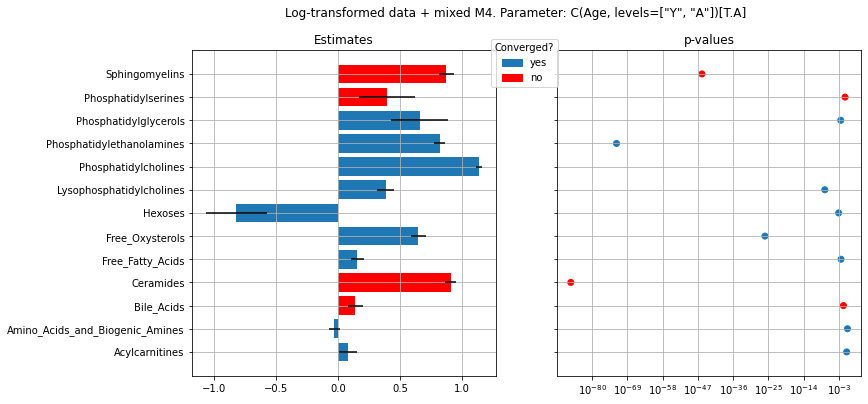

In [22]:
fig, ax = plot_param(param='C(Age, levels=["Y", "A"])[T.A]', results=results_m4_log, model='Log-transformed data + mixed M4.')
attila_utils.savefig(fig, 'estimates-Age_effect-M4_log')

['named-figure/estimates-Age_effect-M4_log_subcls.png',
 'named-figure/estimates-Age_effect-M4_log_subcls.pdf']

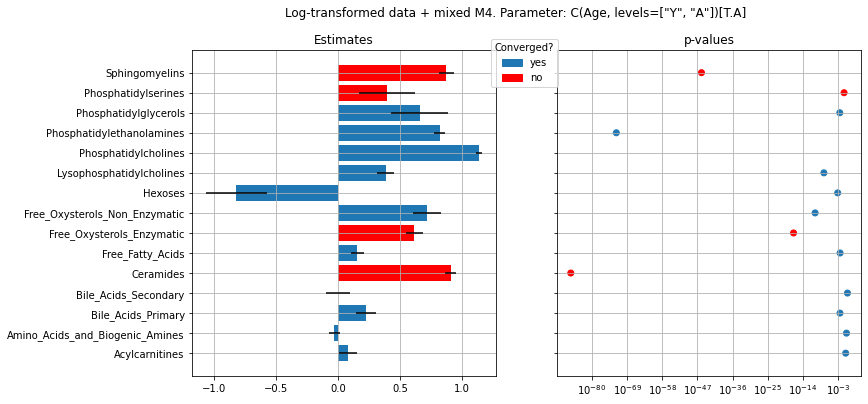

In [23]:
fig, ax = plot_param(param='C(Age, levels=["Y", "A"])[T.A]', results=results_m4_log_subcls, model='Log-transformed data + mixed M4.')
attila_utils.savefig(fig, 'estimates-Age_effect-M4_log_subcls')

### Effect of cognitive performance in aged rats (relative to no effect)

Phosphatidylcholnes and Free_Oxysterols are the most strongly (with the smallest $p$-values) associated to cognitive performance.  For both, the association to LIscore is negative, which means *lower* metabolite levels in cognitively *impaired* animals.  These result on Phosphatidylcholnes is analogous to those by [Rui Chang et al 2020](https://alz-journals.onlinelibrary.wiley.com/doi/10.1002/alz.12675), who found that several Phosphatidylcholnes *decreased* in AD; however, [Toledo et al 2017](https://alz-journals.onlinelibrary.wiley.com/doi/full/10.1016/j.jalz.2017.01.020) found that some Phosphatidylcholines increased during MCI -> AD progression.

Ceramides also appear to be negatively associated to cognitive impairment in aged rats.

['named-figure/estimates-LIscore_effect_in_aged-M4_log.png',
 'named-figure/estimates-LIscore_effect_in_aged-M4_log.pdf']

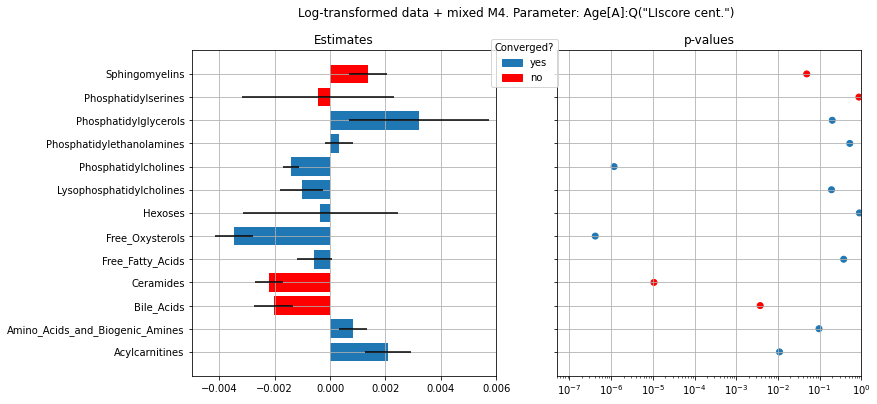

In [24]:
fig, ax = plot_param(param='Age[A]:Q("LIscore cent.")', results=results_m4_log, model='Log-transformed data + mixed M4.')
ax[0].set_xlim(-0.005, 0.006)
ax[1].set_xlim(5e-8, 1)
attila_utils.savefig(fig, 'estimates-LIscore_effect_in_aged-M4_log')

['named-figure/estimates-LIscore_effect_in_aged-M4_log_subcls.png',
 'named-figure/estimates-LIscore_effect_in_aged-M4_log_subcls.pdf']

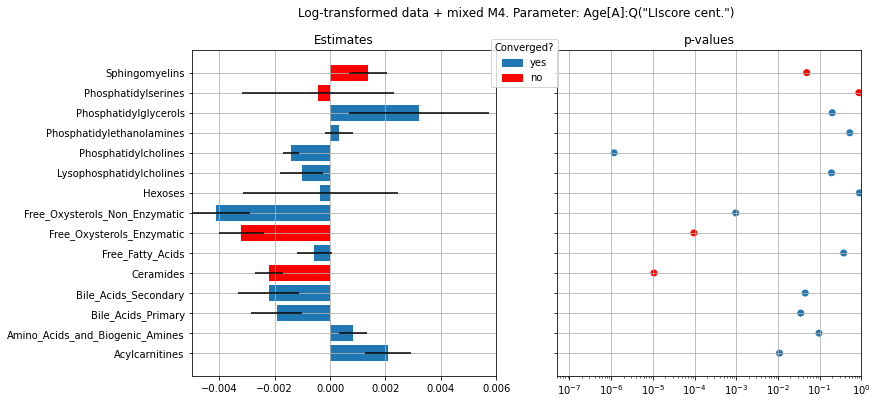

In [25]:
fig, ax = plot_param(param='Age[A]:Q("LIscore cent.")', results=results_m4_log_subcls, model='Log-transformed data + mixed M4.')
ax[0].set_xlim(-0.005, 0.006)
ax[1].set_xlim(5e-8, 1)
attila_utils.savefig(fig, 'estimates-LIscore_effect_in_aged-M4_log_subcls')

### Effect of cognitive performance in young rats

In contrast to aged rats, young rats display no association of average Phosphatidylcholine or Free_Oxysterol level to cognitive performance.  The age dependence of these associations is directly quantified in the next section.

['named-figure/estimates-LIscore_effect_in_young-M4_log.png',
 'named-figure/estimates-LIscore_effect_in_young-M4_log.pdf']

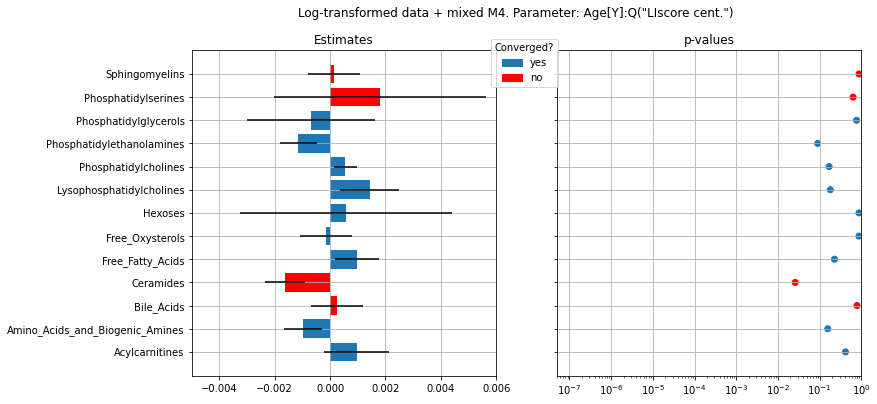

In [26]:
fig, ax = plot_param(param='Age[Y]:Q("LIscore cent.")', results=results_m4_log, model='Log-transformed data + mixed M4.')
ax[0].set_xlim(-0.005, 0.006)
ax[1].set_xlim(5e-8, 1)
attila_utils.savefig(fig, 'estimates-LIscore_effect_in_young-M4_log')

['named-figure/estimates-LIscore_effect_in_young-M4_log_subcls.png',
 'named-figure/estimates-LIscore_effect_in_young-M4_log_subcls.pdf']

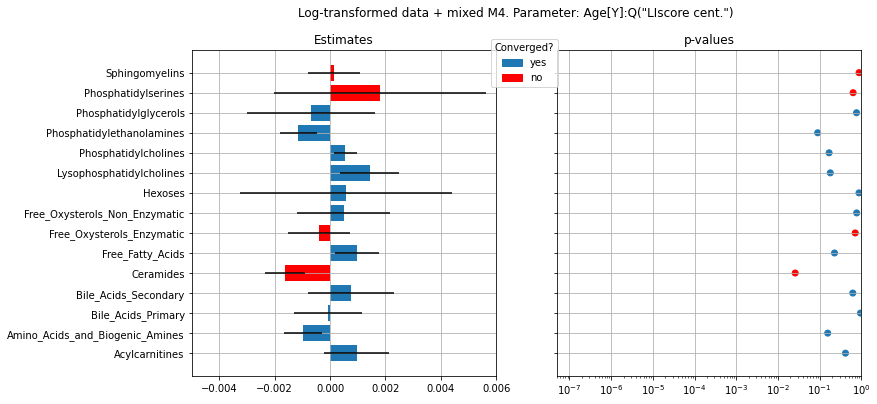

In [27]:
fig, ax = plot_param(param='Age[Y]:Q("LIscore cent.")', results=results_m4_log_subcls, model='Log-transformed data + mixed M4.')
ax[0].set_xlim(-0.005, 0.006)
ax[1].set_xlim(5e-8, 1)
attila_utils.savefig(fig, 'estimates-LIscore_effect_in_young-M4_log_subcls')

### Effect of cognitive performance in aged rats (relative to that in young rats)

Here we see a highly significant age dependence of the association of between cognitive performance and Phosphatidylcholines and Free_Oxysterols.

['named-figure/estimates-LIscore_effect_in_aged-vs-that_in_young-M5_log.png',
 'named-figure/estimates-LIscore_effect_in_aged-vs-that_in_young-M5_log.pdf']

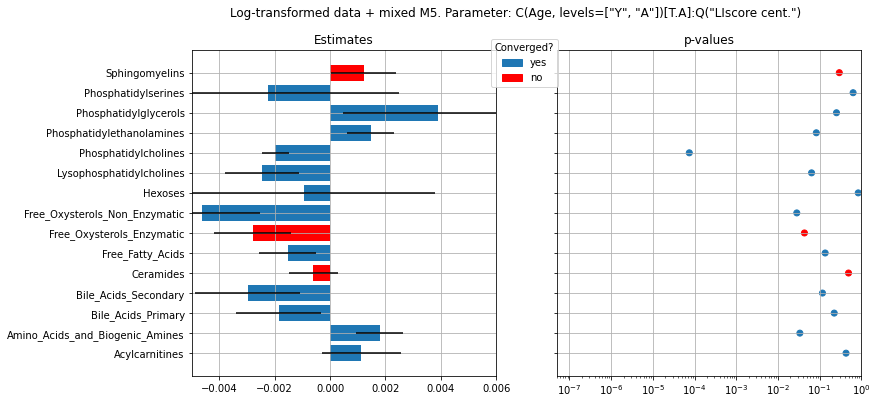

In [28]:
fig, ax = plot_param(param='C(Age, levels=["Y", "A"])[T.A]:Q("LIscore cent.")', results=results_m5_log_subcls, model='Log-transformed data + mixed M5.')
ax[0].set_xlim(-0.005, 0.006)
ax[1].set_xlim(5e-8, 1)
attila_utils.savefig(fig, 'estimates-LIscore_effect_in_aged-vs-that_in_young-M5_log')

['named-figure/estimates-LIscore_effect_in_aged-vs-that_in_young-M5_log_subcls.png',
 'named-figure/estimates-LIscore_effect_in_aged-vs-that_in_young-M5_log_subcls.pdf']

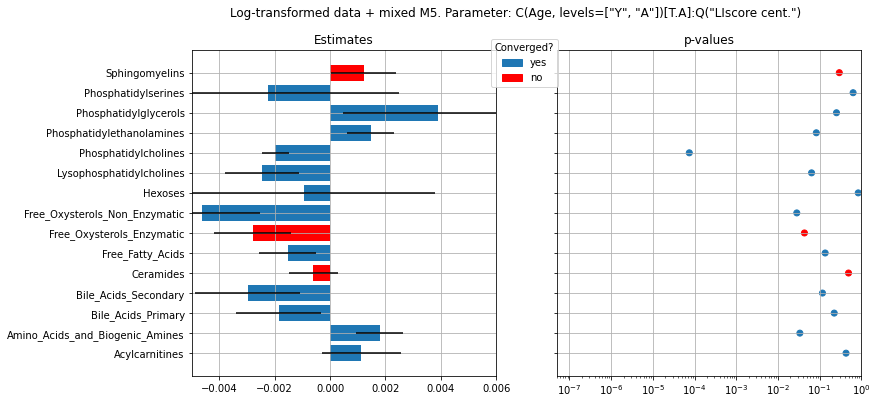

In [29]:
fig, ax = plot_param(param='C(Age, levels=["Y", "A"])[T.A]:Q("LIscore cent.")', results=results_m5_log_subcls, model='Log-transformed data + mixed M5.')
ax[0].set_xlim(-0.005, 0.006)
ax[1].set_xlim(5e-8, 1)
attila_utils.savefig(fig, 'estimates-LIscore_effect_in_aged-vs-that_in_young-M5_log_subcls')

In [30]:
%connect_info

{
  "shell_port": 61073,
  "iopub_port": 61074,
  "stdin_port": 61075,
  "control_port": 61077,
  "hb_port": 61076,
  "ip": "127.0.0.1",
  "key": "5b064de8-5671809988a239466c91188c",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-766df463-a1e3-4d25-a70e-d1f88aa50767.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
